In [1]:
import os, random, optuna, textstat, spacy, re, string, itertools
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import category_encoders as ce

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [2]:
'''Set dataset directory'''
ROOT_DIR = "Z:/Users/Iain/Documents/Data Science Competitions/English Language"

# 1. Exploratory Data Analysis

## 1(a) Profile the dataset

In [10]:
df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

display(df.head())

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [11]:
print("df shape:", df.shape)

df shape: (3911, 8)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


## 1(b) Look at the target variable

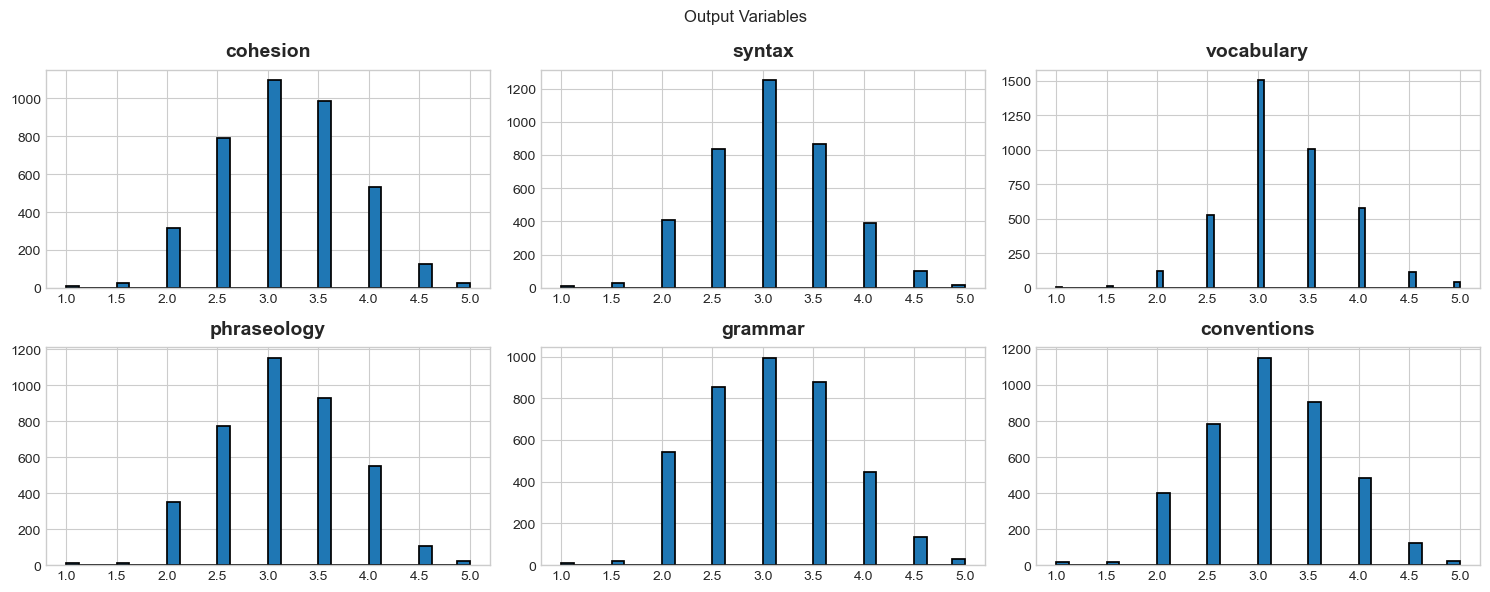

In [14]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

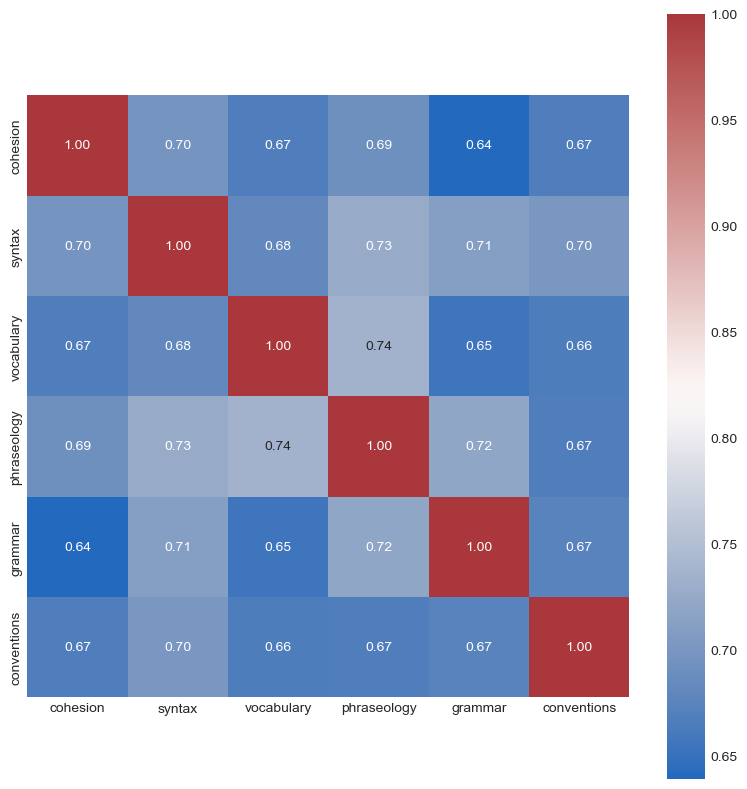

In [51]:
corr = df[targets].corr()
fig, ax = plt.subplots(figsize=(8,8))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="vlag", fmt=".2f")
plt.show()

## 1(c) Text Analysis
- look at word and document statistics, especially as they relate to the target variables
- look at common words

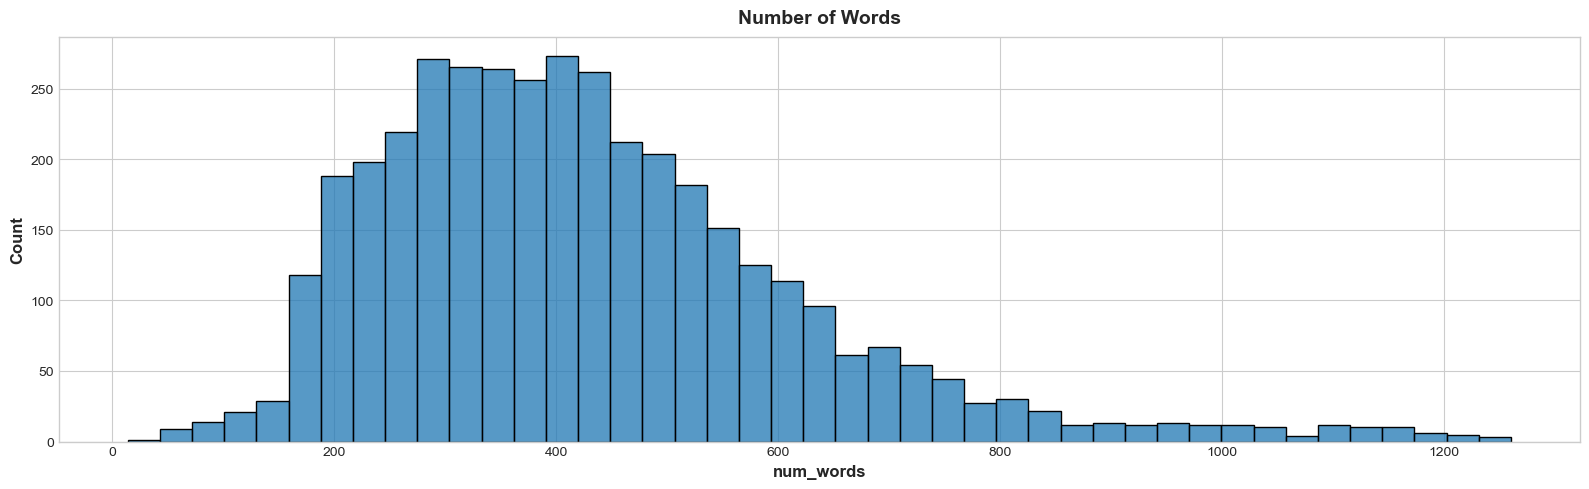

In [19]:
fig = plt.figure(figsize=(16, 5))
df['num_words'] = df['full_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x="num_words")
plt.title("Number of Words")
plt.show()

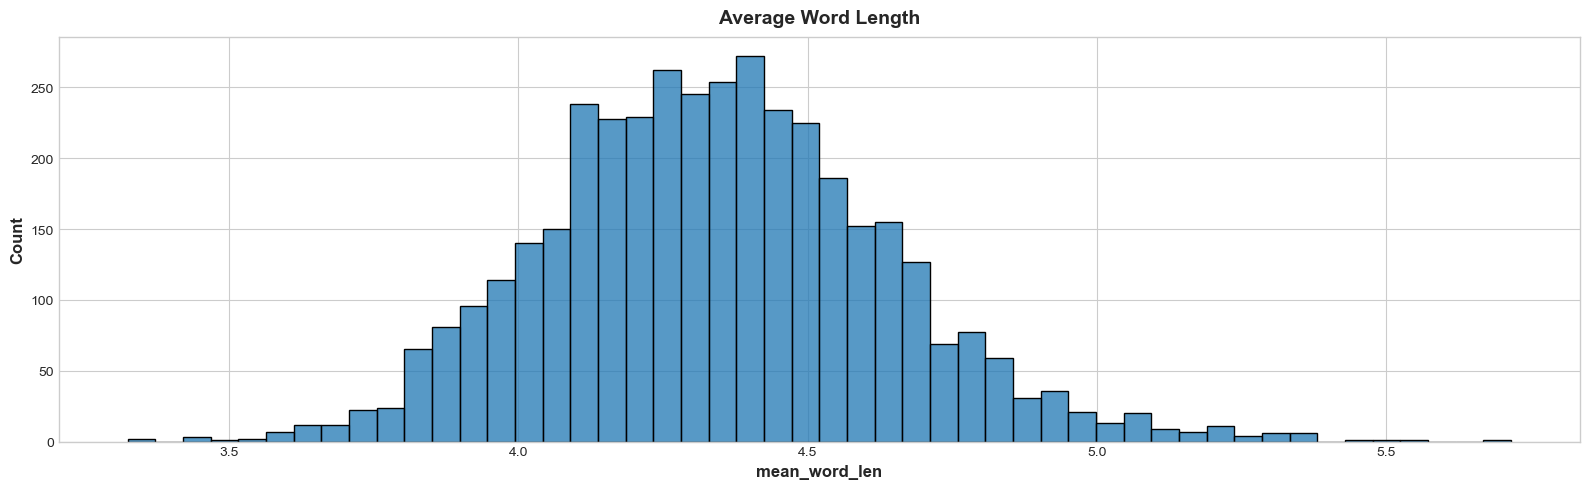

In [21]:
fig = plt.figure(figsize=(16, 5))
df['mean_word_len'] = df['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
sns.histplot(data=df, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

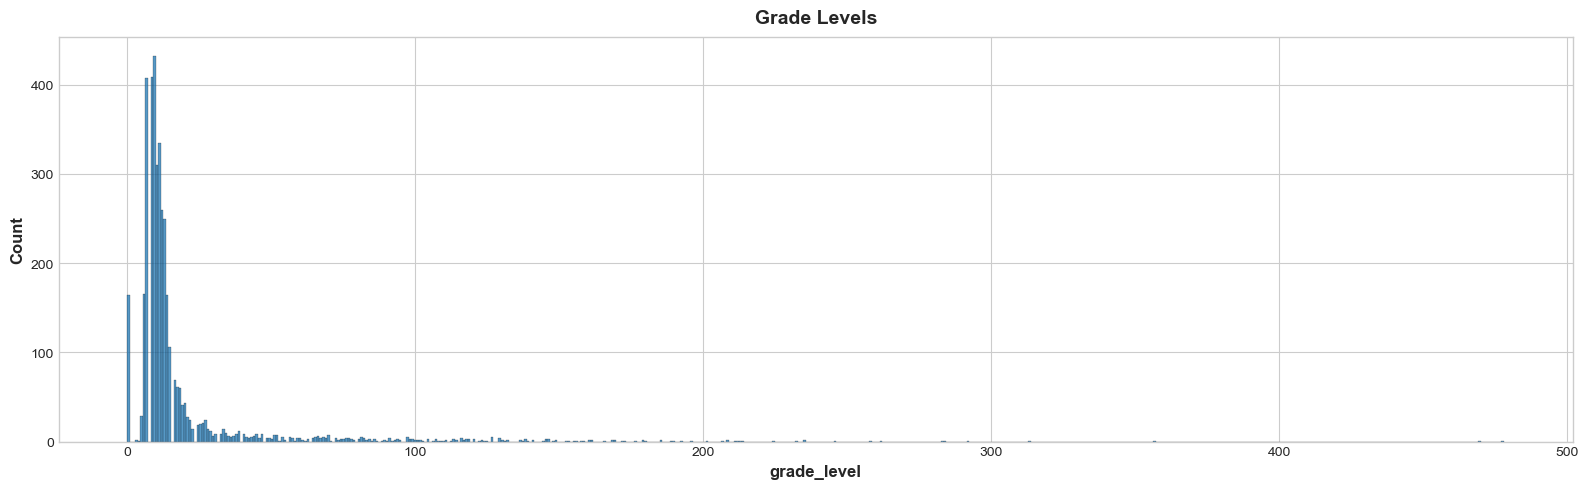

In [29]:
fig = plt.figure(figsize=(16, 5))
df['grade_level'] = df['full_text'].apply(lambda x: textstat.text_standard(x, float_output=True))
sns.histplot(data=df, x="grade_level")
plt.title("Grade Levels")
plt.show()

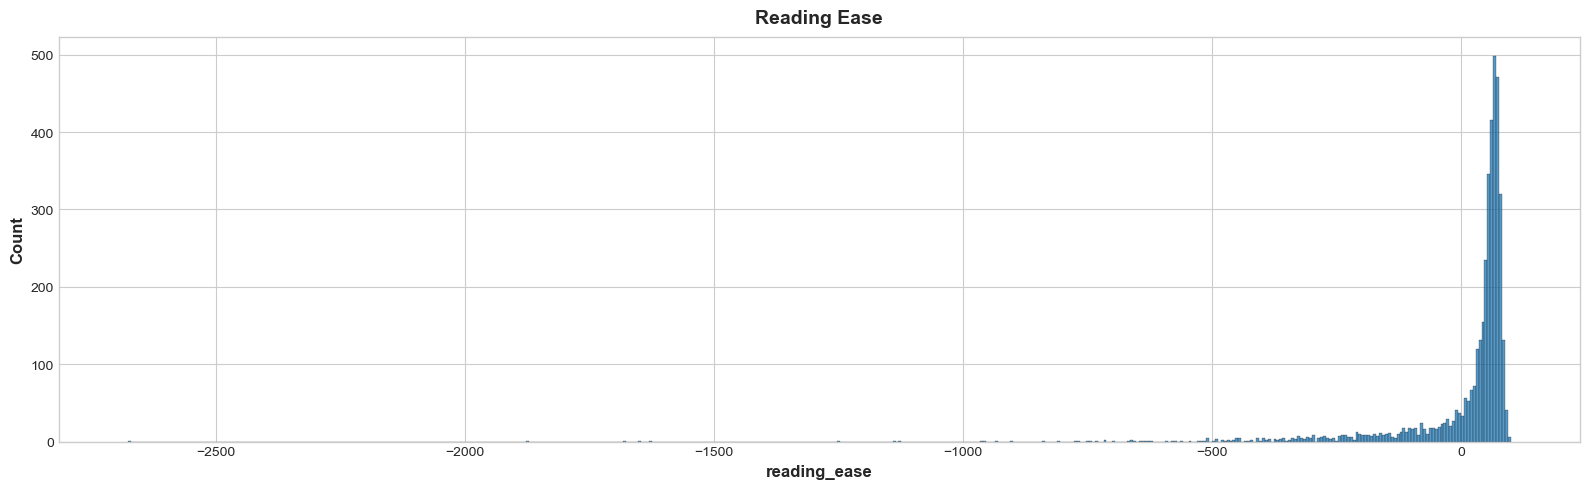

In [24]:
fig = plt.figure(figsize=(16, 5))
df['reading_ease'] = df['full_text'].apply(lambda x: textstat.flesch_reading_ease(x))
sns.histplot(data=df, x="reading_ease")
plt.title("Reading Ease")
plt.show()

In [33]:
'''Look at worst reading ease'''
print(df[df['reading_ease']==df['reading_ease'].min()]['full_text'].values)

["Inteoduction, I planned my paper befoer writing. there are maney school in world. to my paper capturess the reader's attention. the option for students.\n\nThe have distance to learn. The school is an importand in live, you do not delay to the classes. We do benefit from being, because we do not know how to, writering, spelleing it is very important and reading . Also we have serves at school. All people need education. Sam students they do in online, sam in night and daly. To be indebend students.\n\nIn my convenient for me, I learn write, read and speek. When I took my certificate from high school. and then I look for job, I like working to schools and goverment office. I want to help my family and people. when they need.\n\nConclusion, with pleasure, I talking about school. The school is necessarily and beast place in world. is that savety.                                                                                                                                               

In [35]:
'''Look at best reading ease'''
print(df[df['reading_ease']==df['reading_ease'].max()]['full_text'].values)

['Would you like to have more time at school? I would like to have more time at school. Setting at class and learning more things. Getting work done and relaxing. I have three reason why we should have more time at school.\n\nMy first reason why we should have more time at5 school is getting work done. If theres more time at school,then theres more time to do your homework at school. Getting your homework done so you dont have to do ot at home because you finish your work at school. My reason is getting work done.\n\nMy second reason why we should have more time at school is your friends. School can get boring so thats why you have friends so you can hangout with them at school. Your friends can be your work buddy so you and your friends can work together at school so you can finish your work. You can have fun with your friends at school so it wont be so boring i school. My other reason is your friends.\n\nMy third reason why we should have more time at school is your grades. Is your g

In [34]:
'''Look at highest grade level'''
print(df[df['grade_level']==df['grade_level'].max()]['full_text'].values)

["It's a good idea for students to graduate of three years of high school instead of taking for years, i think if they have already passed their classes then they would not have to take elective classes and they might be able to graduate early, but if they need more then seven classes then they might do not be able to graduate and they will have to come during summer to complete their classes that they need to pass.\n\nFor example if they are still missing some of the work they had to complete at the end of the year they would have to come during summer school or maybe take more classes then what they were allow to be taking.\n\nIf they need to complete more work they might come during summer break, i think it would be good if you have all your classes that you need in order to graduate since when you come to ninth grade, so at the end of high school you might just come to skool just for maybe two classes and it would be better for you becase you need to pass all your classes either wa

In [ ]:
'''Look at lowest grade level'''
print(df[df['grade_level']==df['grade_level'].min()]['full_text'].values)

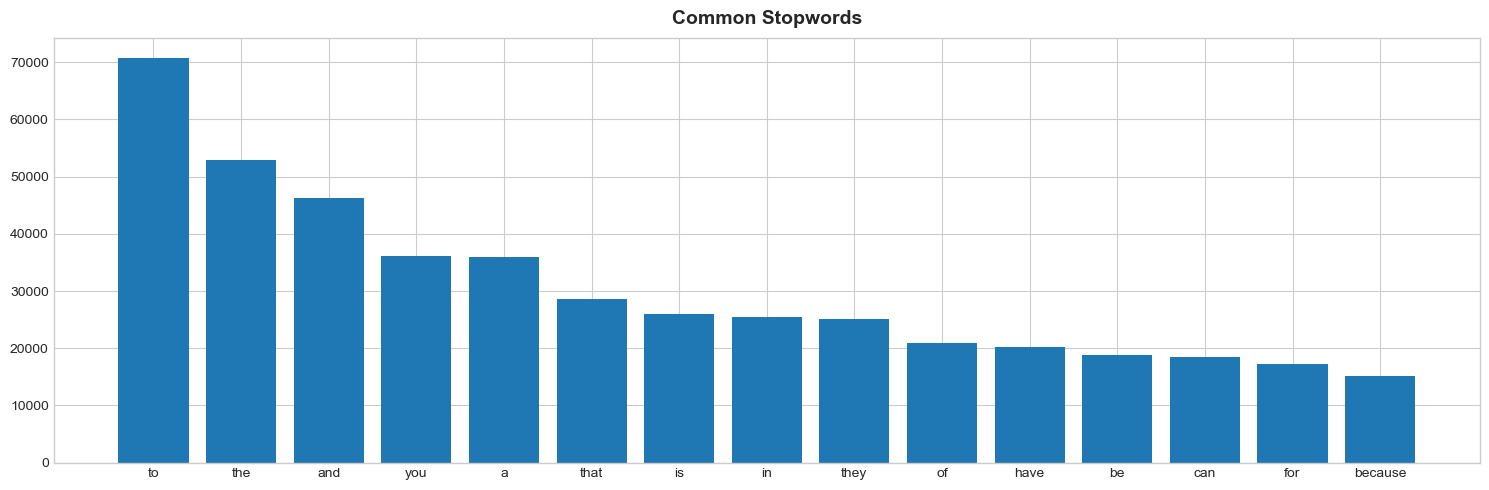

In [47]:
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words('english'))
corpus = ''.join(df.full_text).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15] 
x, y = zip(*top_words)
plt.bar(x, y)
plt.title('Common Stopwords')
plt.show()

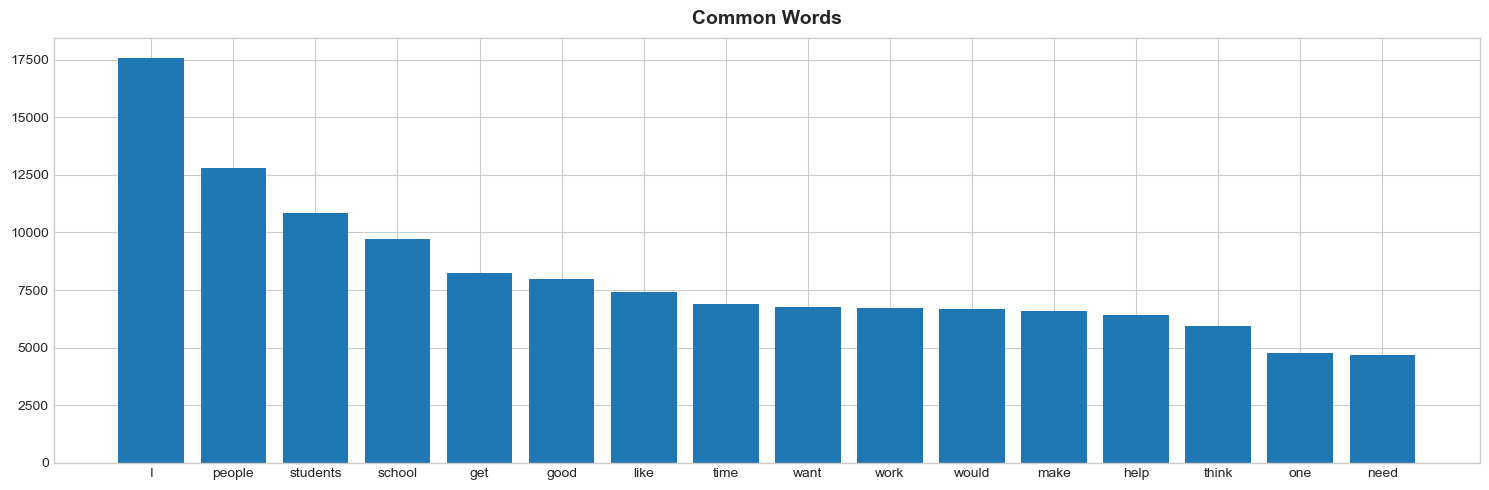

In [50]:
fig = plt.figure(figsize=(15, 5))

counter = Counter(corpus)
words = counter.most_common()

x, y = [], []
i = 0
for word, count in words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)  
        i += 1
    if i > 15:
        break
plt.bar(x, y)
plt.title('Common Words')
plt.show()

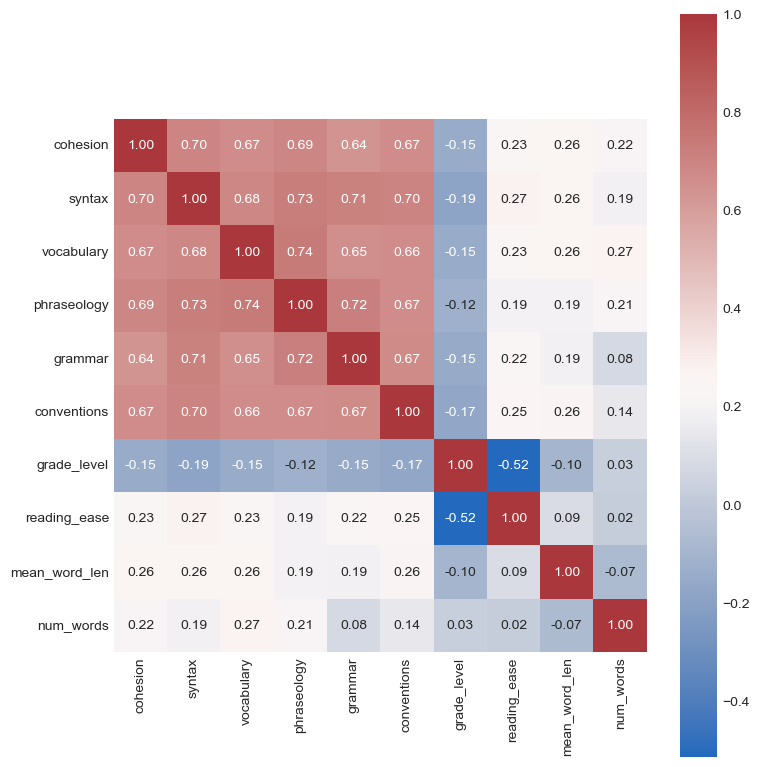

In [52]:
corr = df[targets+['grade_level', 'reading_ease', 'mean_word_len', 'num_words']].corr()
fig, ax = plt.subplots(figsize=(8,8))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="vlag", fmt=".2f")
plt.show()

# 2. Import and Preprocess Data

In [12]:
def preprocess_data(df,  cat_features=None):
    
    # Specify categorical variables
    if cat_features is not None:
        for name in cat_features:
            df[name] = df[name].astype("category")
            # Add a None category for missing values
            if "None" not in df[name].cat.categories:
                df[name].cat.add_categories("None", inplace=True)
                
        df[cat_features] = ce.OrdinalEncoder().fit_transform(df[cat_features])-1

    # create test data set
    train, test = train_test_split(df, test_size=0.2)


    return train, test

In [13]:
df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"), index_col="text_id")
train, test = preprocess_data(df, cat_features=['grammar'])

C:\Users\Iain\AppData\Local\Temp\ipykernel_14228\2607603408.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)


# 3. Set up Configuration

In [14]:
config = {
    'model': 'bert-base-uncased',
    'num_classes' :9,
    'dropout': 0.,
    'batch_size': 32,
    'epochs': 4,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'warmup_steps' : 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'tokenizer' :{
        'max_length': 512,
        'truncation':True
    }
}

# 4. Create Datasets and Dataloaders
- set the classes for the dataset module
- define the tokenizer

In [15]:
class TextDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['grammar']
        self.max_len = config['tokenizer']['max_length']
        self.truncation = config['tokenizer']['truncation']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=self.truncation,
                                          padding='max_length'
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        
        '''NEED to check this for correct output'''
        inputs["labels"] = nn.functional.one_hot(torch.tensor(label, dtype=torch.long), num_classes=config['num_classes'])
        
        return inputs
    
    def __len__(self):
        return len(self.df)

In [16]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

loading configuration file config.json from cache at C:\Users\Iain/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\Iain/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.txt

In [17]:
train_ds = TextDataset(train, config, tokenizer=tokenizer)
test_ds = TextDataset(test, config, tokenizer=tokenizer, is_test=True)

# 5. Define the Model

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(config["model"], num_labels=config["num_classes"])

loading configuration file config.json from cache at C:\Users\Iain/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  

# 6. Model Training

https://huggingface.co/transformers/v3.2.0/custom_datasets.html

In [19]:
training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=config['epochs'],              
    per_device_train_batch_size=config['batch_size'],  
    per_device_eval_batch_size=config['batch_size'],   
    warmup_steps=config['warmup_steps'],               
    weight_decay=config['weight_decay'],              
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_ds,         
    eval_dataset=test_ds           
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [20]:
trainer.train()

Z:\Users\Iain\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3128
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 392
  Number of trainable parameters = 109489161


ValueError: Expected input batch_size (32) to match target batch_size (288).

# 7. Check Predictions

In [21]:
288/32

9.0